# Advanced NLP Workshop

In this workshop, you will learn a number of advanced NLP techniques, with exercises based on a real-world dataset of tweets on #Telstra and #Optus.

**Installing required libraries.**

Install pyLDAvis library for interactive topic visualization dashboard.

In [ ]:
!pip install pyLDAvis

Load libraries.

In [3]:
# Loading primary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For text processing
import re
from textblob import TextBlob
import gensim
import logging
import tempfile
from gensim import corpora, models, similarities
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load data

Load the two datasets (Download from LMS)

In [5]:
df_telstra = pd.read_excel("tp7_telco.xlsx", sheet_name='telstra')
df_optus = pd.read_excel("tp7_telco.xlsx", sheet_name='optus')

In [6]:
# display the column names of the datasets
df_optus.columns

Index(['date', 'content', 'likes', 'retweets', 'authorID', 'name', 'gender',
       'followers', 'following', 'nTweets', 'location', 'tweets', 'day'],
      dtype='object')

In [7]:
df_telstra.columns

Index(['date', 'content', 'likes', 'retweets', 'tweets', 'authorID', 'name',
       'gender', 'followers', 'following', 'nTweets', 'location', 'day'],
      dtype='object')

As the first step, we can select a subset of columns required for our analysis. This can be done based on your business requirement.


In [8]:
df_telstra = df_telstra[['day', 'content']]
df_optus = df_optus[['day', 'content']]

In [9]:
df_optus.head()

,day,content
0,2016-01-01,optus ill giv them a try wen i get home is tha...
1,2016-01-01,optus yeah that'll have to do
2,2016-01-01,optus hi are there problems with cable interne...
3,2016-01-01,optus ->ai
4,2016-01-01,optus /waves to esther y


In [10]:
df_telstra.head()

,day,content
0,2016-01-01,telstra runkeeper i went out for a run.
1,2016-01-01,telstra you too :)
2,2016-01-01,telstra here we are no voice service until at ...
3,2016-01-01,home internet down since yesterday. telstra sa...
4,2016-01-01,three times telstra has said there was an erro...


## Preprocessing

Preprocessing applies to both the datasets.  Instead of duplicating the worm ( as we have to do each step twice (for 2 datasets)), we can combine the two datasets, while keeping track of the original dataset. For that, we create a seperate column ('flag') in both datasets, named 'provider' to indicate the source dataset.

In [11]:
# Create a new flag column for both datasets
df_telstra['provider'] = 'telstra'
df_optus['provider'] = 'optus'

In [13]:
df_telstra.head()

,day,content,provider
0,2016-01-01,telstra runkeeper i went out for a run.,telstra
1,2016-01-01,telstra you too :),telstra
2,2016-01-01,telstra here we are no voice service until at ...,telstra
3,2016-01-01,home internet down since yesterday. telstra sa...,telstra
4,2016-01-01,three times telstra has said there was an erro...,telstra


In [14]:
# combine the 2 datasets
df = pd.concat([df_telstra, df_optus], ignore_index=True)

Now we run the preprocessing.

In [18]:
# Transform sentences into lowercase
df['content'] = df['content'].str.lower()

In [19]:
# Following command is just to visualize the processed dataframe
df.tail()

,day,content,provider
37587,2016-02-29,optus yes and every day since. i have been run...,optus
37588,2016-02-29,optus hi i've been having trouble with my 4g f...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the $40 deal...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


Remove twitter user ids that are mentioned in the tweet text. We will use [regular expressions ](https://www.w3schools.com/python/python_regex.asp) to do this.  
In applying the regular expression, we use the string in the format r"regular-expression". This is to treat the regex as a raw string. Additional information on this can be found from [this stackoverflow question](https://stackoverflow.com/questions/4780088/what-does-preceding-a-string-literal-with-r-mean). 

In [20]:
def remove_twitter_ids(tweet):
  mention_removed_tweet = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", str(tweet)) # remove any sequence of characters followed by '@' sign
  spaces_removed = re.sub(r"\s\s+", " ", str(mention_removed_tweet)) # remove multiple spaces
  return spaces_removed

df['content'] = df['content'].apply(remove_twitter_ids)
df.tail()

,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


In [21]:
# How does above function works?
# Take any tweet that has mentions in it. e.g., https://twitter.com/DavidLKeating/status/1251253645431144457
twt = "Canada just ordered #masks4all for flights. We need this on all US flights NOW. What are we waiting for @SecElaineChao @AmericanAir @Delta @SouthwestAir @united @AlaskaAir @FAANews ??? @jeremyphoward update"
out_twt = remove_twitter_ids(twt)
print(out_twt)

Canada just ordered masks4all for flights We need this on all US flights NOW What are we waiting for update


### Duplicate removal

It is essential we check for duplicates. Because, the tweets are extracted from Twitter API and it is likely the same tweet repeats multiple times.  
We can utilize pandas drop_duplicates() function. [Link to API](https://pandas.pydata.org/pandas-docs/version/0.24.2/reference/api/pandas.DataFrame.drop_duplicates.html)

In [22]:
# Check duplicate tweets count
duplicate_count = len(df['content'])-len(df['content'].drop_duplicates())
print('duplicate count:', duplicate_count)
print('total records before remove duplicates:', df.shape[0])

duplicate count: 1215
total records before remove duplicates: 37592


In [23]:
# drop duplicates (keep the last tweet of each of the duplicates)
df = df.drop_duplicates(subset='content', keep="first")
print('updated record count:', df.shape[0])

updated record count: 36377


Now we will remove all punctuation, retaining just the text.




In [24]:
# Remove punctuations 
df['content'] = df['content'].str.replace(r'[^\w\s]','')  # This is the use of regular expressions.
df.tail()

,day,content,provider
37587,2016-02-29,optus yes and every day since i have been runn...,optus
37588,2016-02-29,optus hi ive been having trouble with my 4g fo...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus your store was not aware of the 40 deal ...,optus
37591,2016-02-29,jozmosis optus that would disqualify a lot of ...,optus


### Stop words and domain related word removal

Now let's conduct further text pre- processing using NLTK library as we did in the first NLP workshop. First, remove stopwords.

In [25]:
#Remove stop words
# Load NLTK library
import nltk

# Download the stopwords to the nltk library
nltk.download('stopwords')

# Load the stopwords
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [26]:
# get the list of all stopwords from the library
stop = stopwords.words('english')

In [27]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Note that the term 'not' is in the stop word list. This will have a negative impact on sentiment analysis. However, if the NLP technique is topic modeling,  there will be no such impact. It is important to keep this mind, drop or retain words depending on the goal of your exercise.  
For this case, we will remove the term 'not' from the stopword list.

In [28]:
stop.remove('not')

In [29]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [30]:
# Remove the words in 'stop' list
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string
  
df['content'] = df['content'].apply(remove_stop_words)
df.tail(5)

,day,content,provider
37587,2016-02-29,optus yes every day since running isolation te...,optus
37588,2016-02-29,optus hi ive trouble 4g last days dont know iv...,optus
37589,2016-02-29,optus clever,optus
37590,2016-02-29,optus store not aware 40 deal 12 month byo dea...,optus
37591,2016-02-29,jozmosis optus would disqualify lot push notif...,optus


In [31]:
# How above function works?
def remove_stop_words(tweet):
  tokens = tweet.split()
  stop_removed_tokens = [t for t in tokens if t not in stop]
  convert_to_string = " ".join(stop_removed_tokens)
  return convert_to_string

txt = "you are the first person."
remove_stop_words(txt)

'first person.'

In [ ]:
# For your knowledge: Same above function can be written as a lambda function
# df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

### Standardization of tweets

We shall use stemming to standardize tweets.  
[Stemming](https://en.wikipedia.org/wiki/Stemming) is the removal of prefix, suffix etc, to derive the base form of a word. We will use the NLTK library.

In [32]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def stemming_function(sent):
  word_list = sent.split()
  stemmed_word_list = [stemmer.stem(word) for word in word_list]
  stemmed_sentence = " ".join(stemmed_word_list)
  return stemmed_sentence

df['content_stem'] = df['content'].apply(stemming_function)

In [33]:
# Compare the content vs. stemmed content
df[['content', 'content_stem']].tail(10)

,content,content_stem
37582,optus net pisses,optu net piss
37583,bulldogchris gus10gould juzweezy case point lo...,bulldogchri gus10gould juzweezi case point loo...
37584,leaveforthecup optus yeah good luck,leaveforthecup optu yeah good luck
37585,dragonsfan1988 gus10gould juzweezy foxtel dead...,dragonsfan1988 gus10gould juzweezi foxtel dead...
37586,dragonsfan1988 gus10gould foxtel overpriced nr...,dragonsfan1988 gus10gould foxtel overpr nrl re...
37587,optus yes every day since running isolation te...,optu ye everi day sinc run isol test 2 week pl...
37588,optus hi ive trouble 4g last days dont know iv...,optu hi ive troubl 4g last day dont know ive p...
37589,optus clever,optu clever
37590,optus store not aware 40 deal 12 month byo dea...,optu store not awar 40 deal 12 month byo deal ...
37591,jozmosis optus would disqualify lot push notif...,jozmosi optu would disqualifi lot push notif g...


The stemming has turned term 'optus' to 'optu', thus, stemming has not deemed expected results in this context.  Thereby, we will go ahead with original content without any standardization.   
You may attempt to lemmatize and see if you can improve the results.

## Word frequency analysis

Let us look at the most occuring words and the least occuring words in our tweet dataset.

In [34]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [35]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

telstra     27434
optus       12871
not          3994
internet     3190
phone        2775
get          2668
service      2641
im           2258
thanks       2210
call         1992
dtype: int64

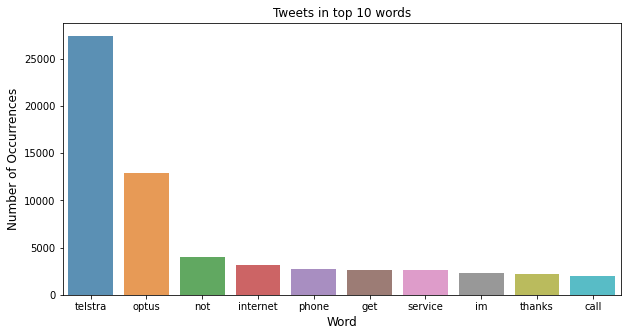

In [36]:
# Visualize the top word counts 

word_count  = word_frequency
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('Tweets in top 10 words')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Word', fontsize=12)
plt.show()

We will now visualize the text corpus that we created after pre-processing to get insights on the most frequently used words.

In [37]:
from PIL import Image
from wordcloud import WordCloud

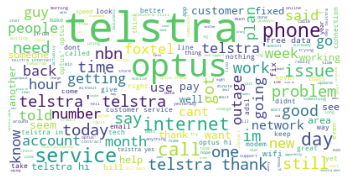

In [38]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

**Insight**  
From the word cloud we could identify that terms telstra and optus has been mentioned frequently. But this is expected - not so much an insight. Therefore, you may remove high frequent yet non-insightful words alongside the twitter specific words.

### Remove common words

Let's  remove context specific words and the most common words from the tweets.

The tweets extracted are from the hashtags @telstra and @optus, these keywords will appear in most tweets. Let's  add those keywords to the set of words to be removed.  
We can extend the new_words list with those additional keywords, which you may think will be widely used due to the area/domain the tweets were extracted.

In [40]:
# Creating a list of custom stopwords
new_words_to_remove = ["pic", "twitter", "com", "telstra", "optus"]

In [41]:
# Remove common words
# We will use lambda function here.
df['content'] = df['content'].apply(lambda x: " ".join(x for x in x.split() if x not in new_words_to_remove))
df.head(5)

,day,content,provider,content_stem
0,2016-01-01,runkeeper went run,telstra,telstra runkeep went run
2,2016-01-01,voice service least mon box door still open,telstra,telstra voic servic least mon box door still open
3,2016-01-01,home internet since yesterday says fixed 6pm 4...,telstra,home internet sinc yesterday telstra say fix 6...
4,2016-01-01,three times said error porting said completed ...,telstra,three time telstra said error port said comple...
5,2016-01-01,last six weeks ed continually porting number a...,telstra,last six week telstra ed continu port number a...


Exercise: try to replicate lambda function above as a python function.

We will re-attempt to compose a frequency appearing word list.

In [42]:
# Create a word frequency series. (This is a pandas series)
word_frequency = pd.Series(' '.join(df['content']).split()).value_counts()

In [43]:
# Look at the top 10 words (you can write either word_frequency[:10] or word_frequency[0:10]. Both give the same result.)
word_frequency[:10]

not         3994
internet    3190
phone       2775
get         2668
service     2641
im          2258
thanks      2210
call        1992
still       1968
data        1761
dtype: int64

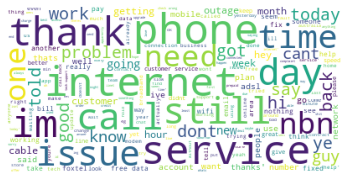

In [44]:
corpus = list(df['content'])

wordcloud = WordCloud(background_color='white', max_words=200, max_font_size=50, random_state=42).generate(str(corpus))

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Bigrams and Trigrams

The following commands will extract bigrams from the tweet dataset.  
From here onwards, we will isolate tweets for each provider to conduct a comparative analysis.

In [45]:
# Seperate the two datasets by using pandas filtering mechanism.
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

### Bigrams

We will use CountVectorizer object from sklearn to generate bi-grams and tri-grams. [Link to API](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)  

You may refer [this StackoverFlow explanation](https://stackoverflow.com/questions/24005762/understanding-the-ngram-range-argument-in-a-countvectorizer-in-sklearn) to understand ngram_range parameter.

In [46]:
# This function will generate most frequently occuring Bi-grams
def get_ngrams(corpus, ngram_range=(2, 2)):
    
    # Create CountVectorizer object from sklearn library with bigrams
    vec1 = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)

    # Create BoW feature representation using word frequency
    bag_of_words = vec1.transform(corpus)

    # compute sum of words
    sum_words = bag_of_words.sum(axis=0) 

    # create (word, frequency) tuples for bigrams
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq

Try out an example to see how this  function works.

In [49]:
txts = ['John likes to watch movies', 'Mary likes movies too', 'Mary also likes to watch football games']
get_ngrams(txts, ngram_range=(4, 4))

[('john likes to watch', 1),
 ('likes to watch movies', 1),
 ('mary likes movies too', 1),
 ('mary also likes to', 1),
 ('also likes to watch', 1),
 ('likes to watch football', 1),
 ('to watch football games', 1)]

In [50]:
bigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(2, 2))
bigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(2, 2))

In [ ]:
bigrams_telstra

Convert bigrams of both datasets to a dataframe with column names bi-gram and frequency.

In [55]:
bigrams_telstra_df = pd.DataFrame(bigrams_telstra)
bigrams_telstra_df.columns=["Bi-gram", "Freq"]

bigrams_optus_df = pd.DataFrame(bigrams_optus)
bigrams_optus_df.columns=["Bi-gram", "Freq"]

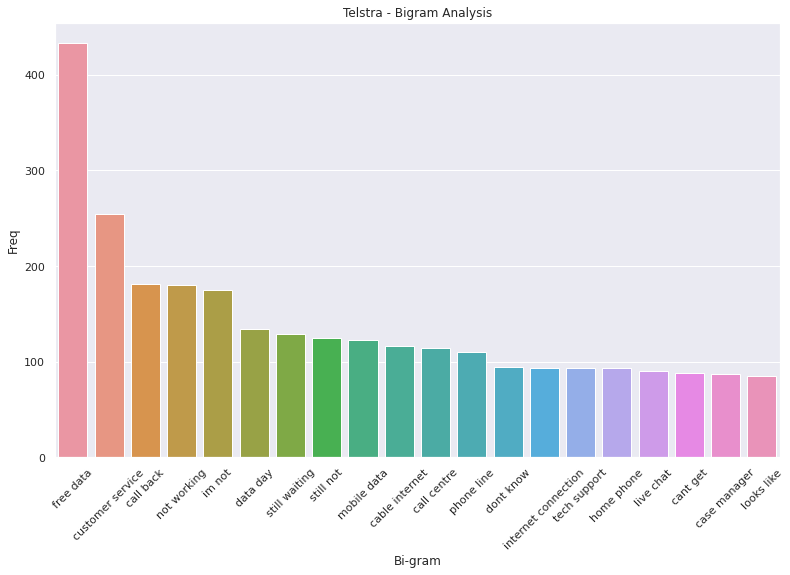

In [ ]:
# Barplot of most freq Bi-grams
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_telstra_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)  # here rotation parameter shows the angle of your x-axis labels
plt.title('Telstra - Bigram Analysis')
plt.show()

**Insights**:  
The bigram 'data day' refers to an event. After a series of outages, Telstra declared a free data day as a compensation. Notice how bigrams can be used to detect such events as well as topics/themes specific to the domain.

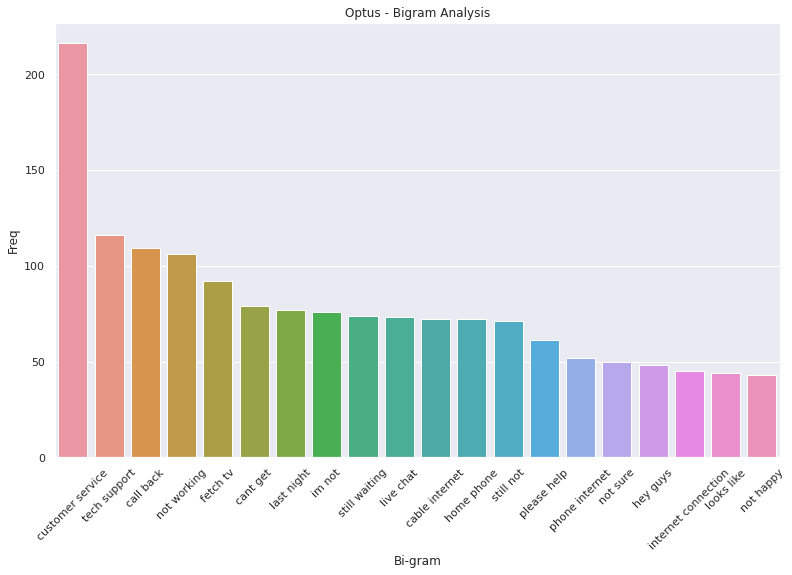

In [57]:
# Barplot of most freq Bi-grams for optus
top_bigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=bigrams_optus_df[:top_bigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.title('Optus - Bigram Analysis')
plt.show()

**Insights:**  
Observe that in Optus dataset, there are many words related to sport which were not prominent in Telstra data. Bigram frequencies can be used to differentiate and compare topics of interest.

### Trigrams

Let's now attempt trigrams. 

In [58]:
trigrams_telstra = get_ngrams(df_telstra_processed['content'].tolist(), ngram_range=(3, 3))
trigrams_optus = get_ngrams(df_optus_processed['content'].tolist(), ngram_range=(3, 3))

Convert tri-grams of both datasets to a dataframe with column names tri-gram and frequency.

In [59]:
trigrams_telstra_df = pd.DataFrame(trigrams_telstra)
trigrams_telstra_df.columns=["Tri-gram", "Freq"]

trigrams_optus_df = pd.DataFrame(trigrams_optus)
trigrams_optus_df.columns=["Tri-gram", "Freq"]

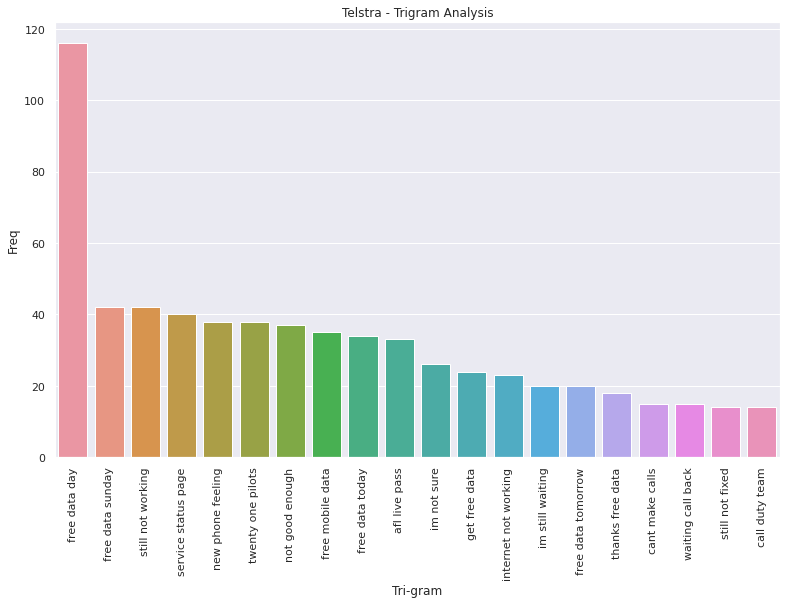

In [60]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_telstra_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Telstra - Trigram Analysis')
plt.show()

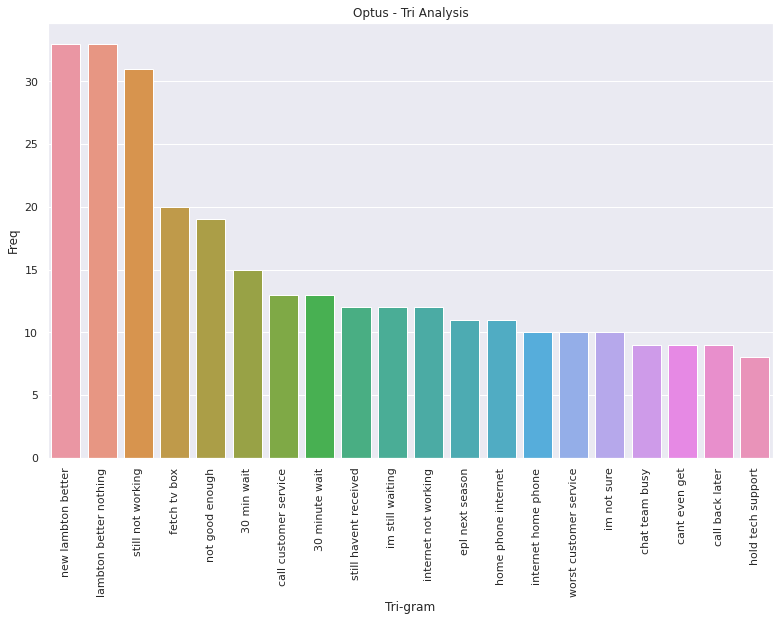

In [ ]:
# Barplot of most freq Tri-grams
top_trigrams_to_show = 20

sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Tri-gram", y="Freq", data=trigrams_optus_df[:top_trigrams_to_show])
h.set_xticklabels(h.get_xticklabels(), rotation=90)
plt.title('Optus - Tri Analysis')
plt.show()

Can you determine new insights from Trigram plots?

## Temporal Analysis

Now let's attempt to explore temporal patterns in the two datasets.

In [70]:
# Group the twitter datasets based on the date field and get the count per each day.
df_telstra_date_wise = df_telstra_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_telstra').set_index('day')
df_optus_date_wise = df_optus_processed.groupby(['day'])['content'].count().reset_index(name='tweet_count_optus').set_index('day')

In [71]:
df_telstra_date_wise.head()

,tweet_count_telstra
day,
2016-01-01,143
2016-01-02,493
2016-01-03,396
2016-01-04,661
2016-01-05,241


In [72]:
df_optus_date_wise.tail()

,tweet_count_optus
day,
2016-02-25,176
2016-02-26,246
2016-02-27,151
2016-02-28,111
2016-02-29,172


When plotting with python, we can change the size of the plot and save it as a figure in your workspace.  
* Change size: plt.figure(figsize=(width, length)) # width and length are in inches  
* Save the image: plt.savefig(filename, dpi)  # dpi is the resolution in pixels

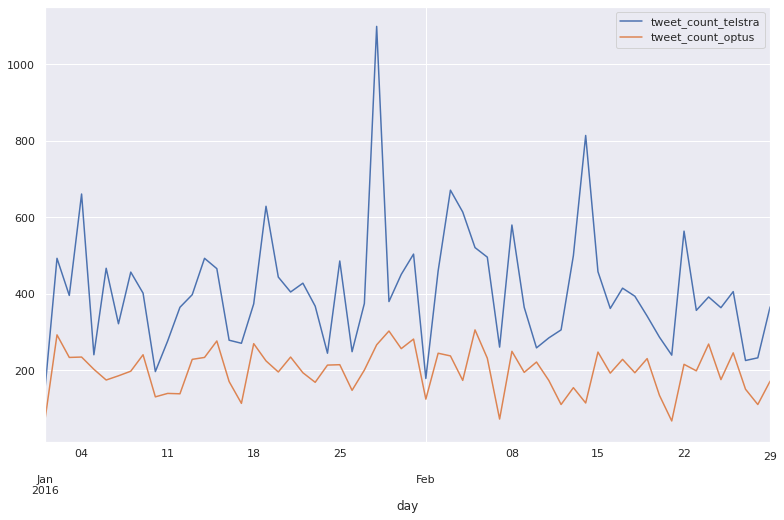

In [115]:
ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v2.png', dpi=800)

Output image is saved in files tab. You can right click on the image and download it to your computer for further analysis.

Insights: How would you describe the two line plots? Any actionable insights?  
Exerciese: Go through the actual Telstra dataset on 2018-01-28, can you explain this spike in tweet count?

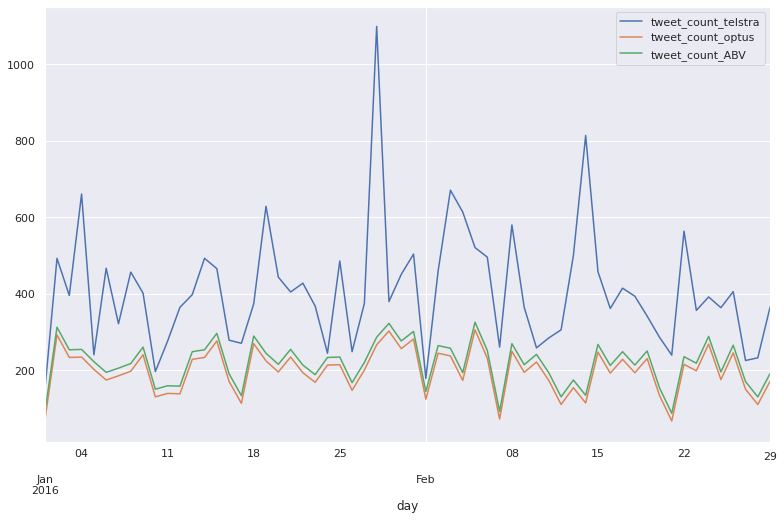

In [116]:
# this is a helper code if you have 3 or more dataframes to compare with.
df_ABC_date_wise =df_optus_date_wise.copy()
df_ABC_date_wise['tweet_count_ABV'] = df_ABC_date_wise['tweet_count_optus'] + 20
del df_ABC_date_wise['tweet_count_optus']

ax = df_telstra_date_wise.plot()
df_optus_date_wise.plot(ax=ax)
df_ABC_date_wise.plot(ax=ax)
plt.savefig('temporal_analysis_v3.png', dpi=800)

## Sentiment Analysis

Analyse sentiments for each tweet, aggregate into the sentiment of particular day and derive a sentiment timeline.

In [76]:
# Extract sentiments from the tweets (This should take some time because we run this to the entire dataset.)
df['sentiment'] = df['content'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
# Display first 50 tweets with respective sentiment value
df[['content', 'sentiment']].head(50)

Again we will conduct invididual analysis for both telcom providers.

In [77]:
df_telstra_processed = df.loc[df['provider'] == 'telstra']
df_optus_processed = df.loc[df['provider'] == 'optus']

Aggregate the sentiment value (using mean) for each provider

In [ ]:
df_telstra_processed

In [ ]:
df_telstra_processed.groupby(['day'])['sentiment'].mean()

In [81]:
df_senti_telstra_date_wise = df_telstra_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_telstra').set_index('day')
df_senti_optus_date_wise = df_optus_processed.groupby(['day'])['sentiment'].mean().reset_index(name='mean_sentiment_optus').set_index('day')

Plot sentiment over time.

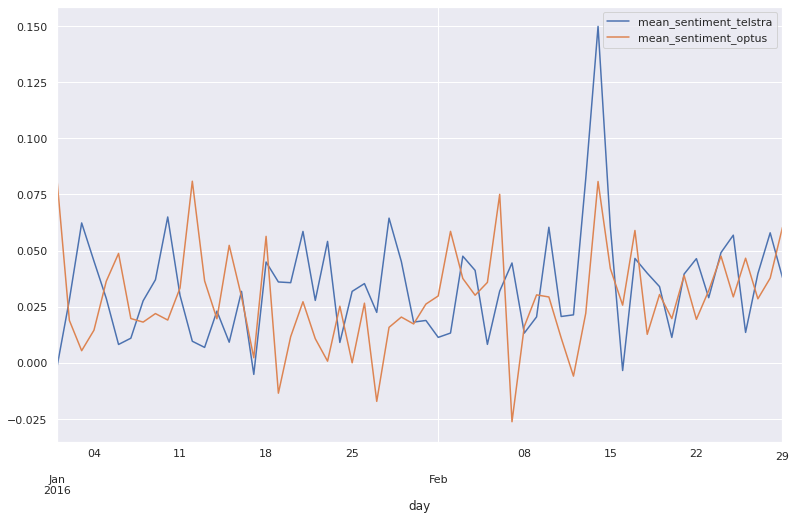

In [85]:
# Plot twitter sentimet timeline over each provider
ax = df_senti_telstra_date_wise.plot()
df_senti_optus_date_wise.plot(ax=ax)
plt.savefig('temporal_sentiment_v2.png', dpi=800)

**Insights:**   
When deriving insights you can refer to days with significant sentiment scores (peaks) and explore the tweets to identify what event has led to positive/negative sentiment.

## Topic Modeling

We will conduct a topic modeling for one of the twitter datasets here (Telstra).  
It is possible to conduct topic modeling using single words, bigrams, trigrams or n-grams.  
Will be using a topic modeling algorithm named - LDA (Latent Dirichlet Allocation) for this task. 

In [90]:
# Setting up the environment for LDA algorithm.

TEMP_FOLDER = tempfile.gettempdir()
print('Folder "{}" will be used to save temporary dictionary and corpus.'.format(TEMP_FOLDER))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Folder "/tmp" will be used to save temporary dictionary and corpus.


In [91]:
# Filter the dataset of the telstra only.
df_telstra_processed = df.loc[df['provider'] == 'telstra']

Now we will create the text corpus.  


In [92]:
# Convert the tweets as the text corpus.
corpus = list(df_telstra_processed['content'])

In [94]:
corpus[:5]

['runkeeper went run',
 'voice service least mon box door still open',
 'home internet since yesterday says fixed 6pm 4jan five days areyoujoking pleaseexplain',
 'three times said error porting said completed wasnt cancelled',
 'last six weeks ed continually porting number amaysim joke']

In [95]:
# Tokenization
telstra_texts = [[word for word in str(document).split()] for document in corpus]

In [ ]:
telstra_texts[:5]

In [98]:
# Create a dictionary based on the tokanized words of all the tweets.
dictionary = corpora.Dictionary(telstra_texts)

# Save the above dictionary as a local file for LDA model to access.
dictionary.save(os.path.join(TEMP_FOLDER, 'telstra.dict'))

2020-08-27 10:06:22,515 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-08-27 10:06:22,654 : INFO : adding document #10000 to Dictionary(13917 unique tokens: ['run', 'runkeeper', 'went', 'box', 'door']...)
2020-08-27 10:06:22,788 : INFO : adding document #20000 to Dictionary(21285 unique tokens: ['run', 'runkeeper', 'went', 'box', 'door']...)
2020-08-27 10:06:22,860 : INFO : built Dictionary(24495 unique tokens: ['run', 'runkeeper', 'went', 'box', 'door']...) from 24482 documents (total 218078 corpus positions)
2020-08-27 10:06:22,861 : INFO : saving Dictionary object under /tmp/telstra.dict, separately None
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-08-27

When creating the dictionary, each tweet (document) is alphabetically sorted before composing the dictionary.

In [99]:
print(telstra_texts[0])
print('alphabetically sorted', sorted(telstra_texts[0]))

['runkeeper', 'went', 'run']
alphabetically sorted ['run', 'runkeeper', 'went']


In [ ]:
print(telstra_texts[1])
print('alphabetically sorted', sorted(telstra_texts[1]))

['voice', 'service', 'least', 'mon', 'box', 'door', 'still', 'open']
alphabetically sorted ['box', 'door', 'least', 'mon', 'open', 'service', 'still', 'voice']


In [ ]:
# Print the dictionary
print(dictionary.token2id)

{'run': 0, 'runkeeper': 1, 'went': 2, 'box': 3, 'door': 4, 'least': 5, 'mon': 6, 'open': 7, 'service': 8, 'still': 9, 'voice': 10, '4jan': 11, '6pm': 12, 'areyoujoking': 13, 'days': 14, 'five': 15, 'fixed': 16, 'home': 17, 'internet': 18, 'pleaseexplain': 19, 'says': 20, 'since': 21, 'yesterday': 22, 'cancelled': 23, 'completed': 24, 'error': 25, 'porting': 26, 'said': 27, 'three': 28, 'times': 29, 'wasnt': 30, 'amaysim': 31, 'continually': 32, 'ed': 33, 'joke': 34, 'last': 35, 'number': 36, 'six': 37, 'weeks': 38, 'already': 39, '4th': 40, 'jan': 41, 'per': 42, 'restored': 43, 'ridiculous': 44, 'tweet': 45, 'bilis': 46, 'hahahaha': 47, 'nang': 48, 'awesome': 49, 'friends': 50, 'future': 51, 'get': 52, 'im': 53, 'missing': 54, 'nye': 55, 'offers': 56, 'text': 57, 'thanks': 58, 'worried': 59, 'bigpond': 60, 'bill': 61, 'charged': 62, 'double': 63, 'find': 64, 'ill': 65, 'movie': 66, 'next': 67, '24': 68, 'gone': 69, 'hit': 70, 'hours': 71, 'long': 72, 'something': 73, 'take': 74, 'trans

In [100]:
# Convert the text dictionary to bag of words model
corpus = [dictionary.doc2bow(text) for text in telstra_texts]

Can you explain this output?

In [ ]:
tweet_id = 0
print(telstra_texts[tweet_id]) # each tweet converted to tokens
print(dictionary.doc2bow(telstra_texts[tweet_id])) # each token is represented as a id from a dictionary

['runkeeper', 'went', 'run']
[(0, 1), (1, 1), (2, 1)]


### Generate the topic model

Recall we initially loaded models library from gensim.  
(from gensim import corpora, models, similarities)

In [109]:
# Construct TF-IDF features from the dictionary.
tfidf = models.TfidfModel(corpus)

2020-08-27 10:12:24,317 : INFO : collecting document frequencies
2020-08-27 10:12:24,318 : INFO : PROGRESS: processing document #0
2020-08-27 10:12:24,346 : INFO : PROGRESS: processing document #10000
2020-08-27 10:12:24,370 : INFO : PROGRESS: processing document #20000
2020-08-27 10:12:24,386 : INFO : calculating IDF weights for 24482 documents and 24494 features (213025 matrix non-zeros)


In [110]:
# Transform the tweets as TF-IDF feature vectors
corpus_tfidf = tfidf[corpus] 

We need to define how many topics we capture through LDA.

In [111]:
total_topics = 40

Below code will build the LDA topic model.   
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.



In [ ]:
lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
corpus_lda = lda[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

The above LDA model is built with 10 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.  
You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.





In [ ]:
# Print the Keyword in the 10 topics
lda.show_topics(total_topics, num_words=6)

How will you interpret this?  
Assume a topic is a represented as '0.020*"nbn" + 0.010*"thanks" + 0.009*"turnbullmalcolm" + 0.009*"mobile" + 0.009*"copper" + 0.008*"buy"'  
  
It means the top 6 keywords that contribute to this topic are: nbn, thanks, turnbullmalcolm, mobile, copper, buy and the weight of ‘nbn’ on topic 5 is 0.020.  
  
The weights reflect how important a keyword is to that topic.  

Looking at these keywords, can you guess what this topic could be? You may summarise it as nbn connectivity (or more specifically Turnbull's decision as Telecommunications Minister to continue using the copper network for the NBN).  

Likewise, can you go through the remaining keyword subsets and infer each topic?  







### Interactive topic analyzer

In [114]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(lda, corpus_lda, dictionary, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
9       66.775887  -14.414407       1        1  12.634126
1      -49.895592 -119.077293       2        1   5.930531
11     -76.880730   73.149742       3        1   5.303232
29      -3.994343  -36.023491       4        1   4.785948
25     -18.379650   29.347696       5        1   4.194575
17     130.096313  -29.678011       6        1   4.130797
27      41.336758   15.499001       7        1   3.743414
35     -56.779751   16.998627       8        1   3.721990
15      65.635284   43.251591       9        1   3.629350
30      33.043747   83.434937      10        1   2.968452
5       18.698759  -60.661064      11        1   2.571806
36      -4.101905   71.203545      12        1   2.455936
19      49.618618  134.511475      13        1   2.441126
39      -0.388713  -95.685753      14        1   2.369844
34     -39.822315   54.227295      15        1   2.349940
6     -133.305725  -32.637161      16        1   2.212397
4       -2.689878  134.564194      17        1   2.031525
10     -94.257729   -7.007202      18        1   1.486662
13      90.285172  -49.108360      19        1   1.463040
22      15.207047   43.795406      20        1   1.435801
37      35.411236  -26.078218      21        1   1.430731
26     -32.027725   92.553101      22        1   1.417750
31      50.124702 -105.401741      23        1   1.413094
20     -53.706627  -25.190823      24        1   1.407974
24     -22.831020   -8.201039      25        1   1.405787
38     -93.259064   33.989895      26        1   1.404572
7      141.271255   17.368738      27        1   1.404499
0      -26.090937  -69.112167      28        1   1.404482
28     -67.346848  128.660202      29        1   1.404438
14    -112.698692  -73.825508      30        1   1.404424
33      96.029938   11.914687      31        1   1.404390
18      71.345497   88.476143      32        1   1.404251
2      -69.040352  -66.979042      33        1   1.404140
32     -96.503647 -136.179550      34        1   1.404139
8       54.851669  -66.913902      35        1   1.404139
16    -117.947960   85.013756      36        1   1.404139
21      11.372697    4.038682      37        1   1.404139
3     -157.806870   12.677388      38        1   1.404139
23     -81.434029 -166.366440      39        1   1.404139
12      10.913463 -131.670151      40        1   1.404139, topic_info=       Term       Freq       Total Category  logprob  loglift
58   thanks  68.000000   68.000000  Default  30.0000  30.0000
408     sim  87.000000   87.000000  Default  29.0000  29.0000
130    data  83.000000   83.000000  Default  28.0000  28.0000
185  better  92.000000   92.000000  Default  27.0000  27.0000
699     bad  77.000000   77.000000  Default  26.0000  26.0000
..      ...        ...         ...      ...      ...      ...
373    need   2.043619   32.116524  Topic40  -4.8718   1.5111
53       im   1.993311  113.892975  Topic40  -4.8967   0.2203
205     hey   1.606521   33.624817  Topic40  -5.1124   1.2246
245    work   1.581986   40.392895  Topic40  -5.1278   1.0258
575     got   1.565862   43.095524  Topic40  -5.1381   0.9508

[2066 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
4314      9  0.931387    03
811       2  0.062213     1
811       4  0.124426     1
811       5  0.435492     1
811      13  0.062213     1
...     ...       ...   ...
559      17  0.941939    yy
2234     17  0.959321   yyy
3993     27  0.904064  yyyy
3339     19  1.232943    yz
1999     24  0.659916  zero

[3388 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 2, 12, 30, 26, 18, 28, 36, 16, 31, 6, 37, 20, 40, 35, 7, 5, 11, 14, 23, 38, 27, 32, 21, 25, 39, 8, 1, 29, 15, 34, 19, 3, 33, 9, 17, 22, 4, 24, 13])

What is the relevance matrix? (The slider on the right)  
Understand what it means and how it can be used to derive more relevant topics from [this paper](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf).

## References

1.   [LDA Topic Modeling](https://youtu.be/3mHy4OSyRf0)
2.   [Topic Modelling in Python - Tutorial](https://ourcodingclub.github.io/2018/12/10/topic-modelling-python.html)